In [114]:
import numpy as np 
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage

## Part1: Loading and Finding the centers of the new clusters

In [6]:
im = np.array(Image.open("im05.png")).astype("double")

In [7]:
def gradient(im):
    sobelx = cv.Sobel(im, cv.CV_64F, 1, 0, ksize=3)
    sobely = cv.Sobel(im, cv.CV_64F, 0, 1, ksize=3)
    grad = (sobelx[:,:,0]**2 + sobely[:,:,0]**2 + sobelx[:,:,1]**2 + sobely[:,:,1]**2 + sobelx[:,:,2]**2 + sobely[:,:,2]**2)**0.5
    return grad

In [84]:
def center_finder(im, k):
    logk = int(np.log2(k))
    k1 = 2**(logk//2)
    k2 = 2**(logk - (logk//2))
    m,n,_ = im.shape
    tile_size = (int(m/k1), int(n/k2))
    centers = []
    for i in range(k1):
        for j in range(k2):
            center = (tile_size[0]//2 + i*tile_size[0], tile_size[1]//2 + j*tile_size[1])
            centers.append(center)
    
    # finding the center with lowest gradient
    im_grad = gradient(im)
    for point in centers:
        min_grad = 10000000
        for i in range(5):
            for j in range(5):
                x = point[0] + i - 2
                y = point[1] + j - 2
                grad = im_grad[x,y]
                if (grad < min_grad):
                    min_grad = grad
                    x_min = x
                    y_min = y
        ind = centers.index(point)
        centers[ind] = (x_min, y_min, im[x_min, y_min, 0], im[x_min, y_min, 1], im[x_min, y_min, 2])
    return centers

In [86]:
def point_drawer(im, points):
    out = im.copy()
    for point in points:
        out = cv.circle(out, (point[1], point[0]), 5, (0,255,0), -1)
    return out.astype("uint8")

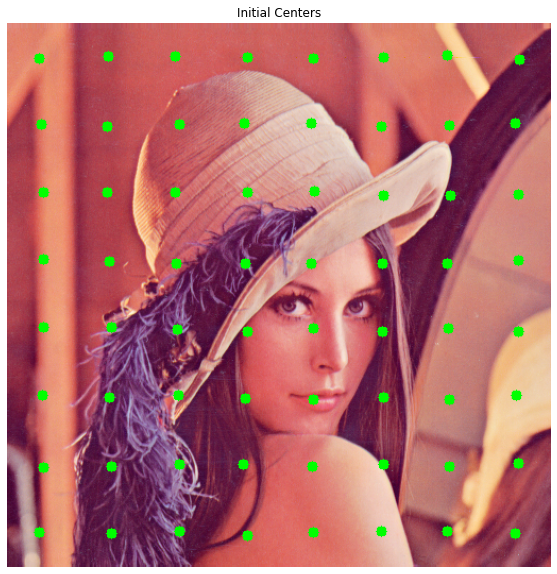

In [87]:
# initial centers
centers = center_finder(im, 64)
plt.figure(figsize=(15,10))
plt.imshow(point_drawer(im, centers))
plt.title("Initial Centers")
plt.axis("off")
plt.show()

## Part 2: Finding the Super Pixels

The function label_assigner, gets the centers of the current superpixel, in an iteration and finds the labels of each pixel and the new centers.

In [91]:
def label_assigner(im, k, centers, alpha):
    m,n,_ = im.shape
    N = m * n
    s = int(np.sqrt(N/k))
    im_label = np.zeros((m,n))
    min_dist_arr = np.ones((m,n))
    min_dist_arr = min_dist_arr * 10000000000
    for k in range(len(centers)):
        x,y,r_center,g_center,b_center = centers[k]
        for i in range(max(x-s, 0), min(x+s+1,m)):
            for j in range(max(y-s,0),min(y+s+1,n)):
                r = im[i,j,0]
                g = im[i,j,1]
                b = im[i,j,2]
                min_D = min_dist_arr[i,j]
                d_xy = ((i - x)**2 + (j - y)**2)**0.5
                d_lab = ((r-r_center)**2 + (g-g_center)**2 + (b-b_center)**2)**0.5
                D = d_lab + alpha * d_xy
                if (D<min_D):
                    min_dist_arr[i,j] = D
                    im_label[i,j] = k
    # finding new centers
    new_centers = []
    for k in range(len(centers)):
        x,y = np.where(im_label == k)
        x_mean = int(np.mean(x))
        y_mean = int(np.mean(y))
        r_mean = int(np.mean(im[x,y,0]))
        g_mean = int(np.mean(im[x,y,1]))
        b_mean = int(np.mean(im[x,y,2]))
        new_centers.append((x_mean, y_mean, r_mean, g_mean, b_mean))
    return im_label, new_centers

The function "super_pixel_finder" uses the "label_assigner" funtion in each iteration and finds the new centers until the difference of the next centers with the current center is lower than a threshold or a limit of iterations. It also generates an image which is created by superpixels.

In [115]:
def super_pixel_finder(im, k, alpha, max_iter, max_err):
    previous_centers = center_finder(im, k)
    err = 10000000
    iters = 0
    while (err > max_err and iters < max_iter):
        im_labels, new_centers = label_assigner(im, k, previous_centers, alpha)
        iters=iters+1
        err = 0
        for i in range(len(new_centers)):
            x_previous, y_previous,_,_,_ = previous_centers[i]
            x_new, y_new, _,_,_ = new_centers[i]
            dist = ((x_new - x_previous)**2 + (y_new - y_previous)**2)**0.5
            err = err +dist
        previous_centers = new_centers
    # applying median filter to im_label
    ndimage.median_filter(im_labels, size = 5)
    new_image = np.zeros(im.shape)
    for i in range(len(new_centers)):
        center = new_centers[i]
        new_image[im_labels == i,0] = center[2]
        new_image[im_labels == i,1] = center[3]
        new_image[im_labels == i,2] = center[4]
    return im_labels, new_centers, new_image.astype("uint8")

In [120]:
im_labels_64, new_centers_64, new_image_64 = super_pixel_finder(im, 64, 0.5, 13, 10)

In [119]:
im_labels_256, new_centers_256, new_image_256 = super_pixel_finder(im, 256, 0.5, 13, 10)

In [121]:
im_labels_1024, new_centers_1024, new_image_1024 = super_pixel_finder(im, 1024, 0.5, 13, 10)

In [122]:
im_labels_2048, new_centers_2048, new_image_2048 = super_pixel_finder(im, 2048, 0.5, 13, 10)

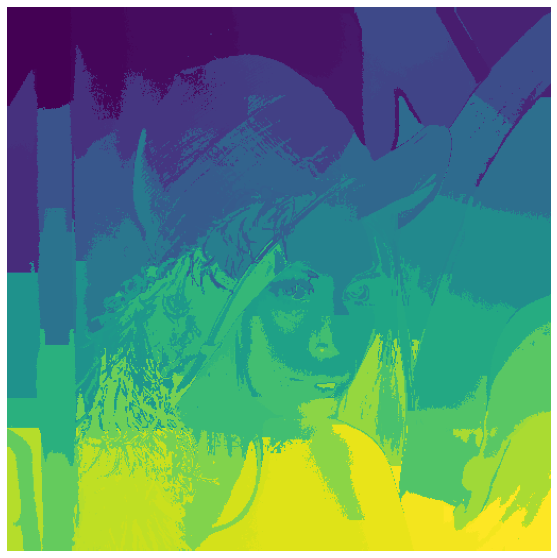

In [137]:
plt.figure(figsize=(10,10))
plt.imshow(im_labels_64)
plt.axis("off")
plt.savefig("results/res14-labels.jpg", dpi=300)
plt.show()

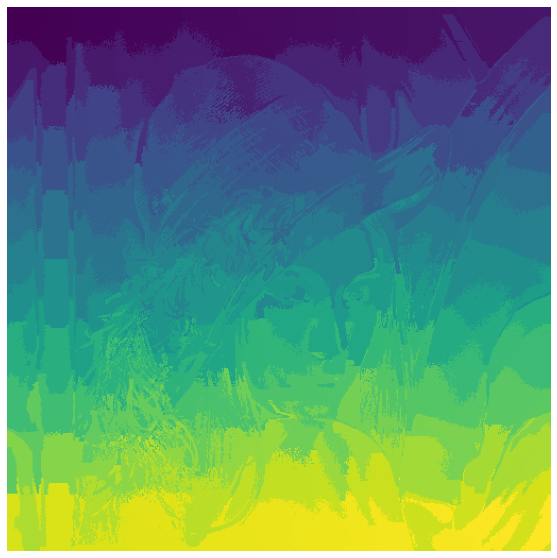

In [138]:
plt.figure(figsize=(10,10))
plt.imshow(im_labels_256)
plt.axis("off")
plt.savefig("results/res15-labels.jpg", dpi=300)
plt.show()

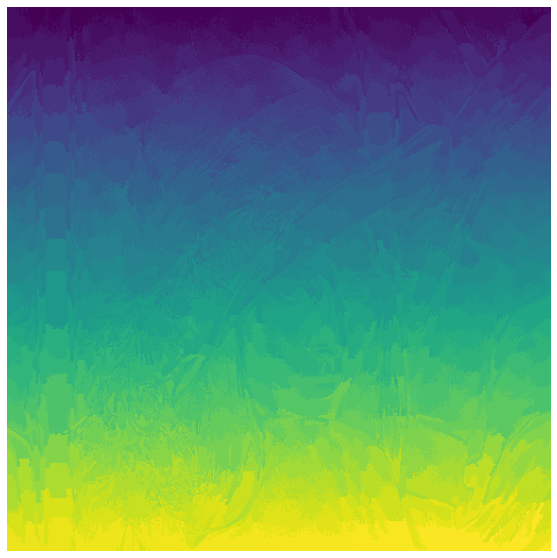

In [139]:
plt.figure(figsize=(10,10))
plt.imshow(im_labels_1024)
plt.axis("off")
plt.savefig("results/res16-labels.jpg", dpi=300)
plt.show()

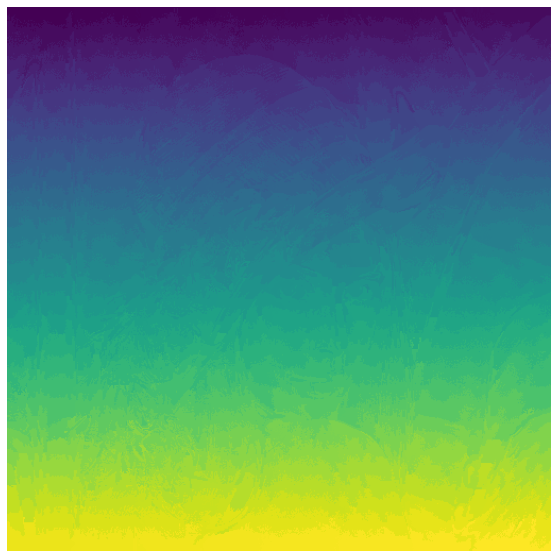

In [140]:
plt.figure(figsize=(10,10))
plt.imshow(im_labels_2048)
plt.axis("off")
plt.savefig("results/res17-labels.jpg", dpi=300)
plt.show()

As can be seen, as we increase the number of the superpixels, we get an image with more details and with smaller superpixels.

## Part 3: Finding Clusters

In [168]:
cluster64 = cv.Canny(image = im_labels_64.astype("uint8"), threshold1 = 15, threshold2 = 40)
cluster256 = cv.Canny(image = im_labels_256.astype("uint8"), threshold1 = 15, threshold2 = 40)
cluster1024 = cv.Canny(image = im_labels_1024.astype("uint8"), threshold1 = 5, threshold2 = 20)
cluster2048 = cv.Canny(image = im_labels_2048.astype("uint8"), threshold1 = 4, threshold2 = 8)

In [169]:
Image.fromarray(cluster64.astype("uint8")).save("results/res18-clusters.jpg", "JPEG")
Image.fromarray(cluster256.astype("uint8")).save("results/res19-clusters.jpg", "JPEG")
Image.fromarray(cluster1024.astype("uint8")).save("results/res20-clusters.jpg", "JPEG")
Image.fromarray(cluster2048.astype("uint8")).save("results/res21-clusters.jpg", "JPEG")

The results of this part and the next part are saved in the files with the given names.

## Part 4: Super Pixels

In [170]:
Image.fromarray(new_image_64.astype("uint8")).save("results/res22-superpixel.jpg", "JPEG")
Image.fromarray(new_image_256.astype("uint8")).save("results/res23-superpixel.jpg", "JPEG")
Image.fromarray(new_image_1024.astype("uint8")).save("results/res24-superpixel.jpg", "JPEG")
Image.fromarray(new_image_2048.astype("uint8")).save("results/res25-superpixel.jpg", "JPEG")